In [2]:
import numpy
import pandas
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import seaborn as sns

sns.set_style("whitegrid")

from scipy.stats import pearsonr
from typing import List

# Conditional Independence

Conditional independence refers to the concept where two variables are independent of each other given the knowledge of a third variable. In other words, once we control for or know the value of this third variable, any observed relationship between the first two variables disappears. This is distinct from simple (unconditional) independence where two variables are unrelated irrespective of the values of any other variables.

To understand conditional indepence, let's look at the simplest possible example we could construct (literally), and take it from there.


## Temperature, shark attacks and ice cream sales

In this very silly example, z drives both x and y (i.e., the data generating process of the system doesn't have any direct connections between x and y, they both depend on z only). But we obviously observe an **unconditional** association between x and y, due to the presence of this **confounder**.


In [3]:
N = 1000
rho = 0.5
eta = 0.3

z = numpy.random.normal(0, 1, N)
x = rho * z + eta * numpy.random.normal(0, 1, N)
y = rho * z + eta * numpy.random.normal(0, 1, N)

> #### Correlations
>
> ... are ways of quantifying the joint distribution of the data. Which in this case point out that there is a relationship between **x** and **y**


PearsonRResult(statistic=np.float64(0.7521931366802013), pvalue=np.float64(5.439530029528811e-183))


<Axes: >

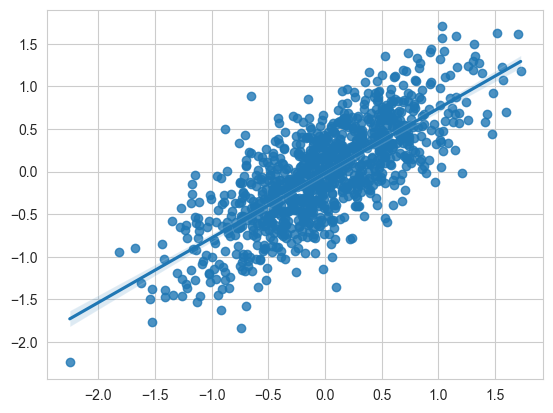

In [4]:
print(pearsonr(x, y))
sns.regplot(x=x, y=y)

> #### Confounders
>
> ... are variables that is both associated with the exposure of interest and the outcome of interest, but is not on the causal pathway between the exposure and outcome. The presence of a confounder can lead to spurious or biased associations between the exposure and outcome, making it seem like there's a relationship when there isn't one, or obscuring a real relationship.

In this case, **Z** is the confounder between **X** and **Y**.


### Partial Correlation

What if we want to remove the effect of **Z** and test whether there's a residual association between **X** and **Y** that is **independent** of **Z**?

We can try the following:

1. Regress Z on X, look at the residuals of X given Z
2. Regress Z on Y, look at the residuals of Y given Z
3. Measure the association of the residuals.


In [5]:
Z = z.reshape(-1, 1)

model = LinearRegression()
x_bar = model.fit(Z, x).predict(Z) - x

model = LinearRegression()
y_bar = model.fit(Z, y).predict(Z) - y

PearsonRResult(statistic=np.float64(0.01923629895431321), pvalue=np.float64(0.5434524130790341))


<Axes: >

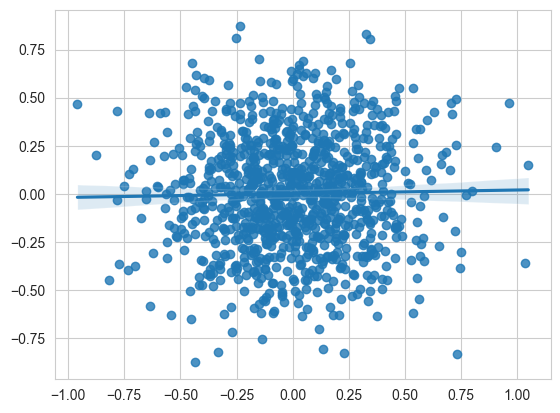

In [6]:
print(pearsonr(x_bar, y_bar))
sns.regplot(x=x_bar, y=y_bar)

> #### Partial correlation
>
> measures the relationship between two variables while controlling for the effects of one or more additional variables. Essentially, it quantifies the association between two variables, removing the influence of the specified control variables. In this way, partial correlation provides insight into the direct relationship between variables of interest, isolated from potential confounding effects.

In this example, the partial _pearson_ correlation of **X** and **Y** given **Z** is statistically insignificant, as expected.


## More variables, same idea

What if x and y are driven by multiple variables? We would have to remove the effect of all variables!


In [7]:
N = 1000
rho_z = 0.5
rho_w = 0.5
eta = 0.3

z = numpy.random.normal(0, 1, N)
w = numpy.random.normal(0, 1, N)
x = rho_z * z + rho_w * w + eta * numpy.random.normal(0, 1, N)
y = rho_z * z + rho_w * w + eta * numpy.random.normal(0, 1, N)

df = pandas.DataFrame({"z": z, "w": w, "x": x, "y": y})

In [8]:
df.corr().style.background_gradient(axis=None, vmin=0, vmax=1, cmap="YlGnBu").format(
    precision=1
)

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [9]:
def partial_pearson(
    data: pandas.DataFrame,
    x: str,
    y: str,
    Z: List[str] = [],
    p_value_threshold: float = 0.05,
):

    for elm in Z:
        assert elm in data
    assert x in data
    assert y in data

    assert x not in Z
    assert y not in Z

    if len(Z) == 0:
        corr = pearsonr(data[x], data[y])

    else:
        Z_data = data[Z]
        x_data = data[x]
        y_data = data[y]

        model = LinearRegression()
        x_bar = model.fit(Z_data, x_data).predict(Z_data) - x_data

        model = LinearRegression()
        y_bar = model.fit(Z_data, y_data).predict(Z_data) - y_data

        corr = pearsonr(x_bar, y_bar)

    significant = corr.pvalue < p_value_threshold

    return {
        "magnitude": corr.correlation,
        "pvalue": corr.pvalue,
        "is_associated": significant,
    }

In [10]:
partial_pearson(df, "x", "y", [])

{'magnitude': np.float64(0.8439945605323689),
 'pvalue': np.float64(2.9277918161558685e-272),
 'is_associated': np.True_}

In [11]:
partial_pearson(df, "x", "y", ["z"])

{'magnitude': np.float64(0.7236767490251519),
 'pvalue': np.float64(6.325292749289652e-163),
 'is_associated': np.True_}

In [12]:
partial_pearson(df, "x", "y", ["w"])

{'magnitude': np.float64(0.7248266047741544),
 'pvalue': np.float64(1.0995903470695498e-163),
 'is_associated': np.True_}

In [13]:
partial_pearson(df, "x", "y", ["z", "w"])

{'magnitude': np.float64(-0.012930859965873499),
 'pvalue': np.float64(0.6829687736733889),
 'is_associated': np.False_}

As expected, in order to really remove the effect of the confounders, we need to remove the effect of both **Z** and **W**.

> #### _d_-separation,
>
> ...refers to a criterion used to determine whether two sets of nodes are independent given a third set. If the nodes are \(d\)-separated, then they are conditionally independent given the observed variables. \(d\)-separation is vital in understanding confounding, mediating effects, and determining if a certain relationship is identifiable solely based on the observed data and the underlying causal graph.


## Successfully failing

Let's observe that **Z** and **W** are **unconditionally independent**. But what happens when we control for either **X** or **Y**?


In [14]:
partial_pearson(df, "w", "z", [])

{'magnitude': np.float64(0.02687949139726336),
 'pvalue': np.float64(0.39582873886386133),
 'is_associated': np.False_}

In [15]:
partial_pearson(df, "w", "z", ["x"])

{'magnitude': np.float64(-0.7268189289845115),
 'pvalue': np.float64(5.193467401691674e-165),
 'is_associated': np.True_}

In [16]:
partial_pearson(df, "w", "z", ["y"])

{'magnitude': np.float64(-0.7141411227107892),
 'pvalue': np.float64(9.0572470247741e-157),
 'is_associated': np.True_}

In [17]:
partial_pearson(df, "w", "z", ["y", "x"])

{'magnitude': np.float64(-0.8400510879603025),
 'pvalue': np.float64(2.5974903515176947e-267),
 'is_associated': np.True_}

> #### Collider
>
> is a specific type of node or variable in a causal path diagram or graphical model. It is where two or more causal paths converge, meaning it is caused by two or more variables. For instance, if \(A\) causes \(C\) and \(B\) also causes \(C\), then \(C\) is a collider on the path between \(A\) and \(B\). Interestingly, conditioning on a collider can introduce an association between the variables leading into it, potentially leading to spurious correlations or confounding in causal analyses.


Discoverying a **collider** is extremely important, as we will see later.


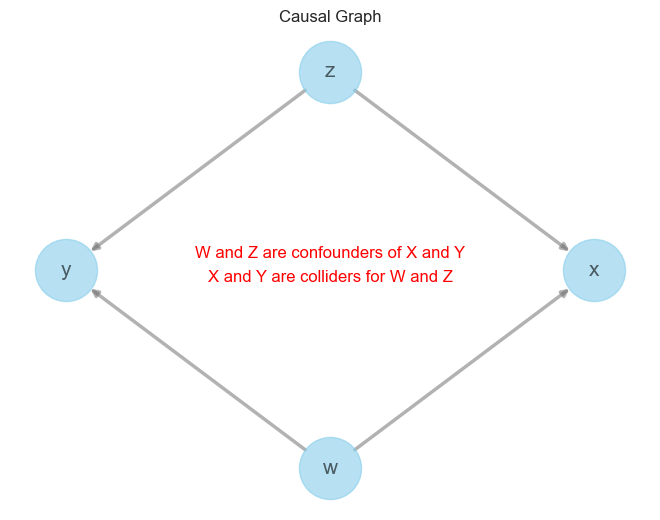

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define nodes and edges
nodes = ["x", "z", "y", "w"]
edges = [("w", "x"), ("w", "y"), ("z", "x"), ("z", "y")]

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Plot the graph
pos = nx.circular_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,
    node_color="skyblue",
    font_size=15,
    width=2.5,
    alpha=0.6,
    edge_color="gray",
)
plt.title("Causal Graph")

# Annotations
annotation1 = "W and Z are confounders of X and Y"
annotation2 = "X and Y are colliders for W and Z"
plt.annotate(
    annotation1,
    xy=(0.5, 0.525),
    xycoords="axes fraction",
    ha="center",
    fontsize=12,
    color="red",
)
plt.annotate(
    annotation2,
    xy=(0.5, 0.475),
    xycoords="axes fraction",
    ha="center",
    fontsize=12,
    color="red",
)

plt.show()

## Homework!

1. Improve this function so that it **scales** (we're gonna need it!)
2. What about nonlinear or categorical data?
   - How would you build the same, but for **spearman/kendall**?
   - What about more complex association metrics, could you build a test using **conditional mutual information**?
